# Assignment 05
# Due: Monday July 8th, 2024, 3:59 PM
# Late submissions until July 10th, 3:59 PM
## Instructions:
1. Once the notebook is completed, export to .py file.  Submit both the notebook and the .py file.  To do this, click export at the top of the notebook or ctrl + shift + p at the top of the notebook and type in export.  Export to python file should show up as a search result.  Also:
    - Ensure that your .py file is an exact replica of your .ipynb file.  
    - Ensure your .py and .ipynb files run successfully without any errors.  You should be able to click `Run All` in VS Code and run the notebook without error before converting to a .py file.  When completed, you should be able to run the .py file from the terminal or command prompt.
2. DO NOT submit the data from the assignment and keep your data file and python file in the same directory. Do not use your local directory path to read files (e.g., avoid using paths like C:/your/directory/file.csv).  Just read in the file directly as if though it was in the same directory as your .ipynb file.  DO NOT CHANGE THE NAME OF THE FILE....
3. Whenever we ask to .head(10) the results or print out a value, please use `print()` so for example `print(df.head(10))`. Print only the answers to the questions that have been asked.  Do not print the head of a dataset unless explicitly asked. 
4. Whenever displaying a graph use `plt.show()`
5. For theoretical answers/short answers, please use print() (e.g., print("your answer")).
6. Wherever we have code displayed to print out values, use that code as a template to print out your output.  For example, if we give you `print(f'Threshold for best accuracy: {}')` please use code in this style to print out your output.  For some questions, this is only a template as we expect you to print out multiple answers (For example....Fit a linear regression model to each of the 5 features INDIVUDALLY and print out the slope and intercept for each. (Don't forget train/test split) requires you use the template for each feature)
7. Do not include pip install commands in your code. You can assume that all required libraries are already installed.

# Assignment 5: SVM With Real Estate Data

## Instructions:

For this assignment we are going to use the northeast_realestate.parquet file that we did in the first assignment.  We will basically:

1. Complete some basic EDA
2. Filter out bad data
3. Create a train test split
4. Fit an SVM and a Logistic Regression to compare
5. Use GridSearchCV to find the best parameters for an SVM and analyze the best model

1. Import data and packages here.  Import parquet file using `pd.read_parquet("northeast_realestate.parquet")`.  Print out the head of the dataframe.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
data = pd.read_parquet('northeast_realestate.parquet', engine='pyarrow')
print(data.head())

      price  bed  bath  acre_lot                  street          city  \
0  225000.0  3.0   1.0      3.93            326 River Rd    Willington   
1  579900.0  4.0   3.0      2.34           32 Heather Ln      Coventry   
2   65000.0  1.0   1.0       NaN  63 Schofield Rd Apt 34    Willington   
3  215000.0  2.0   1.0      0.91              353 Rye St  East Windsor   
4  144900.0  2.0   1.0      0.36         24 Worcester Rd        Vernon   

         state  zip_code  house_size  sold_date  
0  Connecticut    6279.0      1572.0       None  
1  Connecticut    6238.0      3320.0   6/1/2021  
2  Connecticut    6279.0       680.0  8/16/2019  
3  Connecticut    6016.0       960.0   6/6/2012  
4  Connecticut    6066.0       860.0   9/2/2016  


2. Print out the shape of the dataframe

In [3]:
print(data.shape)


(517505, 10)


3. Create a new feature like we did in class called `'citystate'` that is a combination of the city and state separated by an underscore.  Print out the head of this new column.

In [4]:
data['citystate'] = data['city']+'_'+data['state']
print(data['citystate'].head())

0      Willington_Connecticut
1        Coventry_Connecticut
2      Willington_Connecticut
3    East Windsor_Connecticut
4          Vernon_Connecticut
Name: citystate, dtype: object


4. Filter only on 'Staten Island_New York','Worcester_Massachusetts','Manhattan_New York' and 'Portland_Maine' and print out the shape of the resultant data frame

In [5]:
q = "(citystate==['Staten Island_New York','Worcester_Massachusetts','Manhattan_New York','Portland_Maine'])"
data = data.query(q)
print(data.shape)

(20001, 11)


# EDA

5. For each column in this new data frame, print out the number of null values, the number of not null values and the percent of nulls in each column. You can either put all values in a data frame and print it out or loop through the columns and print them out separately

In [6]:
for c, v in data.items():
    print((f'Column: {c}\n Number null: {v.isnull().sum()}\n Number not null: {v.notnull().sum()}\n Proportion null: {v.isnull().sum()/v.shape[0]}'))

Column: price
 Number null: 0
 Number not null: 20001
 Proportion null: 0.0
Column: bed
 Number null: 1705
 Number not null: 18296
 Proportion null: 0.08524573771311435
Column: bath
 Number null: 768
 Number not null: 19233
 Proportion null: 0.0383980800959952
Column: acre_lot
 Number null: 7642
 Number not null: 12359
 Proportion null: 0.3820808959552022
Column: street
 Number null: 21
 Number not null: 19980
 Proportion null: 0.0010499475026248687
Column: city
 Number null: 0
 Number not null: 20001
 Proportion null: 0.0
Column: state
 Number null: 0
 Number not null: 20001
 Proportion null: 0.0
Column: zip_code
 Number null: 0
 Number not null: 20001
 Proportion null: 0.0
Column: house_size
 Number null: 3904
 Number not null: 16097
 Proportion null: 0.1951902404879756
Column: sold_date
 Number null: 8821
 Number not null: 11180
 Proportion null: 0.4410279486025699
Column: citystate
 Number null: 0
 Number not null: 20001
 Proportion null: 0.0


6. Select only the 'price','bed','bath','house_size' and 'citystate' variables and drop the nulls and drop the duplicates.  Print the head of the dataset.

In [7]:
data = data[['price','bed','bath','house_size','citystate']].dropna().drop_duplicates()
print(data.head())

          price  bed  bath  house_size       citystate
95335  319000.0  3.0   1.0       992.0  Portland_Maine
95387  314900.0  4.0   2.0      2272.0  Portland_Maine
95399  409000.0  3.0   2.0      1351.0  Portland_Maine
95404  424900.0  3.0   2.0      1656.0  Portland_Maine
95406  500000.0  3.0   2.0      1535.0  Portland_Maine


7. Print the shape of this new dataframe

In [8]:
print(data.shape)

(1919, 5)


8. Create a pair scatter plot of all the numeric variables (all the variables except the citystate).  I think we learned how to do this in `03_data_prep_and_preprocessing_notebook_02.ipynb`

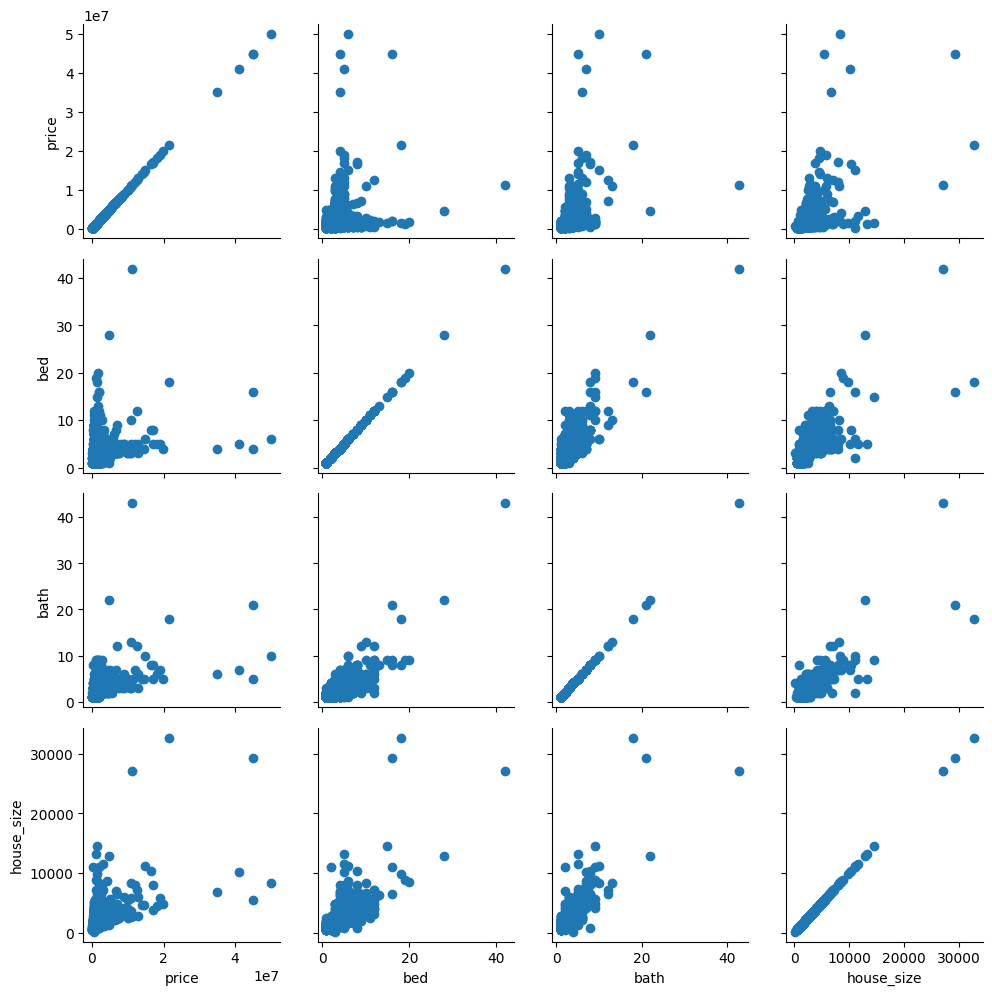

In [9]:
g = sns.PairGrid(data.drop(columns=['citystate']))
g.map(plt.scatter)
plt.show()

9. Which variables seem to be correlated with eachother?

In [10]:
print("""Number of bed and bath,  house size and bed as well as house size and bath seems to have the highest correlation""")

Number of bed and bath,  house size and bed as well as house size and bath seems to have the highest correlation


10. Create two column plots displaying the count of observations for all values of bed and bath

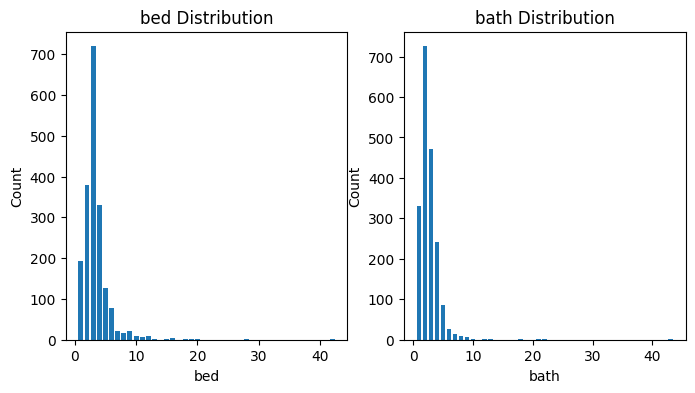

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (8,4))

variables = ['bed','bath']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel(var)

plt.show()

11. Print out the row(s) for the properties with the highest number of beds.  Do any bed values seem like outliers?  Does the price seem to match your intuition about the number of beds?

In [12]:
properties = data.dropna().drop_duplicates().sort_values(by='bed',ascending=False)
print(f'Row with highest number of beds:\n{properties.head(5)}')
print("""Your answer here""")

Row with highest number of beds:
             price   bed  bath  house_size                citystate
370842  11200000.0  42.0  43.0     27152.0   Staten Island_New York
369010   4649000.0  28.0  22.0     12825.0   Staten Island_New York
136492   1795000.0  20.0   9.0      8500.0  Worcester_Massachusetts
136417   1100000.0  19.0   9.0      8814.0  Worcester_Massachusetts
136221   1349974.0  18.0   8.0      9868.0  Worcester_Massachusetts
Your answer here


12. Create a histogram of the price

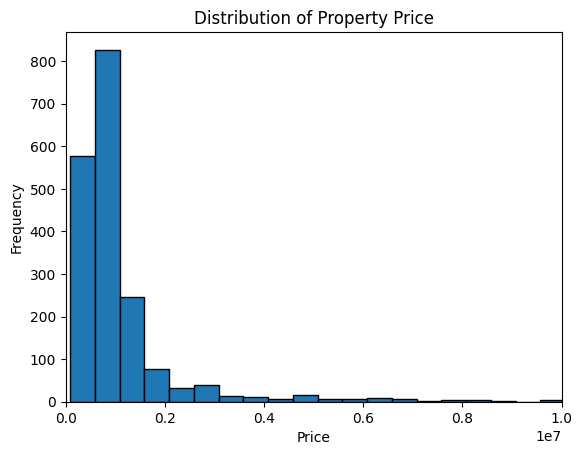

In [13]:
plt.hist(data['price'], bins=100, edgecolor = 'black')
plt.title('Distribution of Property Price')
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.xlim(left=0, right=1*1e7)
plt.show()

13. Is the price skewed?  What type of transformation (see `03_data_prep_and_preprocessing_notebook_02.ipynb`) should we use to transform a value with such extreme values?

In [14]:
print("""Yes, the price is skewed left, we can use log transformation to transform the data""")

Yes, the price is skewed left, we can use log transformation to transform the data


14. Plot a histogram of the transformed price.  Does it look more normal?

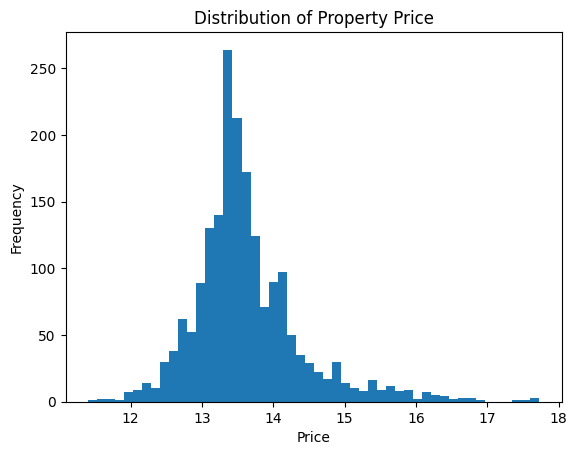

Yes, this is more normally distributed now


In [15]:
plt.hist(np.log(data['price']), bins=50)
plt.title('Distribution of Property Price')
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.show()
print("""Yes, this is more normally distributed now""")

15. Do the same for house_size. Plot the histogram of house_size

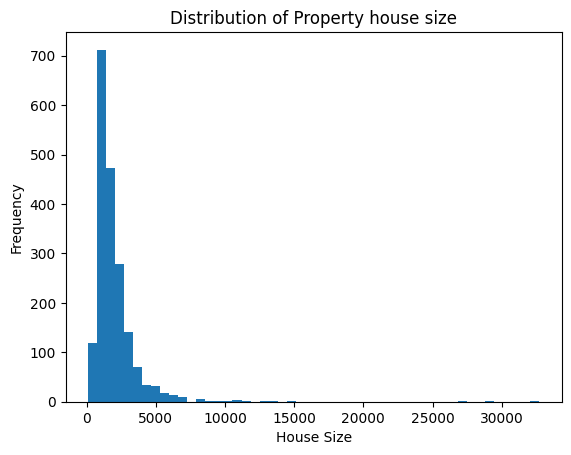

In [16]:
plt.hist(data['house_size'], bins=50)
plt.title('Distribution of Property house size')
plt.ylabel('Frequency')
plt.xlabel('House Size')
plt.show()

16. Should house_size be transformed?

In [17]:
print("""Yes, this should be transformed as it skewed left""")

Yes, this should be transformed as it skewed left


17. Plot a histogram of transformed house_size.  Does is appear more normal?

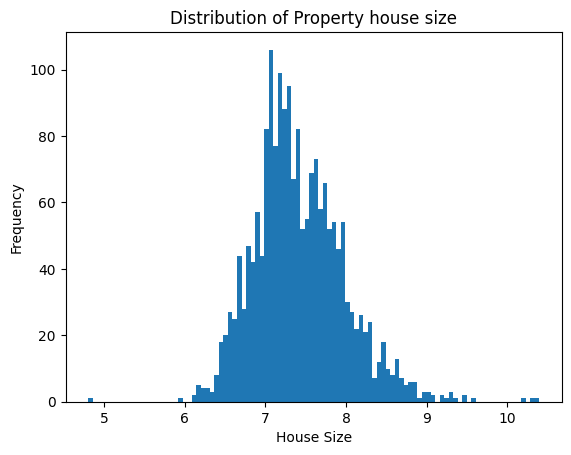

Yes, this is more normal


In [18]:
plt.hist(np.log(data['house_size']), bins=100)
plt.title('Distribution of Property house size')
plt.ylabel('Frequency')
plt.xlabel('House Size')
plt.show()
print("""Yes, this is more normal""")

18. Create a correlation matrix for the numeric variables.   Use a heatmap and the "flare" color palette

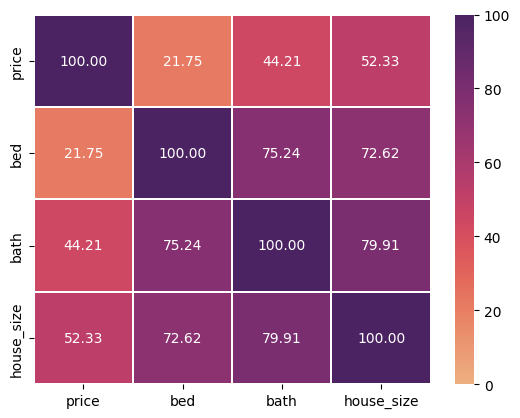

In [19]:
corr = data.drop(columns='citystate').corr() * 100
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=100,
            fmt=".2f", cmap=sns.color_palette("flare", as_cmap=True))
plt.show()

19.  What variables are most correlated?  If we were to complete PCA in this assignment (which we aren't), which X variables would be good candidates for combining for PCA?

In [20]:
print("""The variables that are more correlated are: Bed and Bath, House Size and Bath, Bed and House Size""")

The variables that are more correlated are: Bed and Bath, House Size and Bath, Bed and House Size


20.  Calculate and print out the percentage of rows by citystate.

In [21]:
citystate_counts = data['citystate'].value_counts()
total_count = data['citystate'].shape[0]

row_percentage = round((citystate_counts / total_count) * 100,6)

print(f'The row percentage by CityState is: \n\n{row_percentage}')

The row percentage by CityState is: 

citystate
Staten Island_New York     69.671704
Manhattan_New York         17.457009
Worcester_Massachusetts     7.087024
Portland_Maine              5.784263
Name: count, dtype: float64


21. Is the data set balanced?  Which citystate combination occurs the most?  The least?

In [22]:
print("""No, the data is not balanced. The citystate that occurs the most is Staten Island_New York and the one that occur the least is Portland_Maine""")

No, the data is not balanced. The citystate that occurs the most is Staten Island_New York and the one that occur the least is Portland_Maine


22. Create your X and y variables.  Transform house_size and price the way we did above.  Your y, or target variable, should be citystate.

In [23]:
data['house_size'] = np.log(data['house_size'])
data['price'] = np.log(data['price'])

X = data.drop(columns='citystate')
y = data['citystate']

23. Create a train test split.  Use 0.20 test size and random_state = 42.  Print the shape of your x train, x test, y train and y test data sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

24. Print out the proportion of observations by citystate.

In [25]:
print(f'The proportion of observation by city is: {y_train.value_counts()/y_train.shape[0]}')

The proportion of observation by city is: citystate
Staten Island_New York     0.693160
Manhattan_New York         0.175896
Worcester_Massachusetts    0.071661
Portland_Maine             0.059283
Name: count, dtype: float64


25.  Does the distribution of values match the overall data set?

In [26]:
print("""Yes, it is closer to the original datasets. """)

Yes, it is closer to the original datasets. 


26. Override your train test split, except stratify by the y variable

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

27. Print out the distribution of y values.

In [28]:
print(f'The y values distribution is: \n\n{y_train.value_counts()/y_train.shape[0]}')

The y values distribution is: 

citystate
Staten Island_New York     0.696417
Manhattan_New York         0.174593
Worcester_Massachusetts    0.071010
Portland_Maine             0.057980
Name: count, dtype: float64


28.  Is the distribution of your y values closer to the original dataset?

In [29]:
print("""Yes, it is close to original datasets.""")

Yes, it is close to original datasets.


29. Scale your training data using `fit_transform` and then use `transform` to transform the test data as well using the same scaler (don't call `fit_transform again`, just `fit`).  Print out the head of your scaled X data.

In [30]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
X_scaled = np.concatenate([X_train_scaled, X_test_scaled])
print(f"Train Data: \n{pd.DataFrame(X_scaled, columns=X_train.columns).head()}")

Train Data: 
      price       bed      bath  house_size
0 -0.269304 -0.600582 -0.364440   -0.663838
1 -1.799856 -1.034210 -0.897217   -1.461834
2 -0.184886 -0.166954 -0.364440   -0.865491
3  1.498444  0.700302  1.233891    2.625804
4 -0.223505 -0.166954  0.168337   -0.013808


30. Create a separate scatter plot of your training data (or use a FacetGrid and use col='citystate') for each citystate with price on the x axis and house_size on the y.

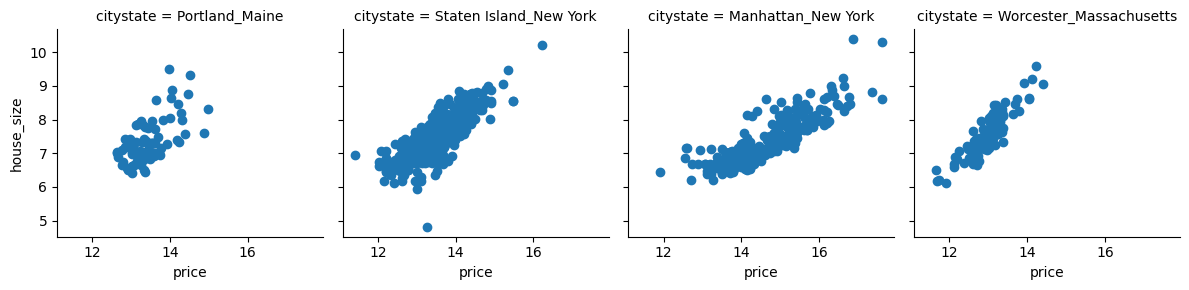

In [31]:
train_data = X_train.copy()
train_data['citystate']= data['citystate'][X_train.index]
g = sns.FacetGrid(train_data, col='citystate')
g.map(plt.scatter, 'price', 'house_size')
plt.show()

31.  Create a single scatter plot with price on the x and house_size on the y.  Color the observations by citystate and add a legend.

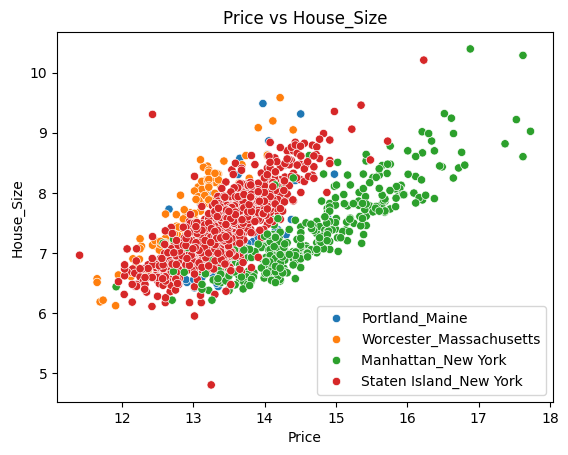

In [32]:
sns.scatterplot(data=data, x=data['price'], y=data['house_size'], hue=data['citystate'])
plt.title('Price vs House_Size')
plt.xlabel('Price')
plt.ylabel('House_Size')
plt.legend()
plt.show()

32. Which citystates seem like they might be the most easy to categorize or separate using these two variables, from what you can see in your graphs.  Which ones seem like they will be more difficult to separate?

In [33]:
print("""Manhattan_New York and Staten Island_New York seem to be easy to separate. Portland_Maine and Worcester_Massachusetts are more difficult to separate.""")

Manhattan_New York and Staten Island_New York seem to be easy to separate. Portland_Maine and Worcester_Massachusetts are more difficult to separate.


33. Fit a logistic regression and print out the accuracy_score and f1_score (use the macro average) for the training and testing data

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_test_pred = logreg.predict(X_test_scaled)
y_train_pred = logreg.predict(X_train_scaled)
print(f'The Test data accuracy is: {metrics.accuracy_score(y_test, y_test_pred)} \nand the F1_score is: {
      metrics.f1_score(y_test,y_test_pred, average='macro')}')


print(f'The Train data accuracy is: {metrics.accuracy_score(y_train, y_train_pred)} \nand the F1_score is: {
      metrics.f1_score(y_train,y_train_pred, average='macro')}')

The Test data accuracy is: 0.875 
and the F1_score is: 0.6193256697975943
The Train data accuracy is: 0.8586319218241042 
and the F1_score is: 0.5823512368866967


34. Do the same, except with a SVC.  Use C=1 and gamma=1.

In [35]:
svc = SVC(C=1, gamma=1)
svc.fit(X_train_scaled, y_train)

y_test_pred = svc.predict(X_test_scaled)
y_train_pred = svc.predict(X_train_scaled)

print(f'The Test data accuracy is: {metrics.accuracy_score(y_test, y_test_pred)} \nand the F1_score is: {
      metrics.f1_score(y_test,y_test_pred, average='macro')}')

print(f'The Train data accuracy is: {metrics.accuracy_score(y_train, y_train_pred)} \nand the F1_score is: {
      metrics.f1_score(y_train,y_train_pred, average='macro')}')

The Test data accuracy is: 0.8854166666666666 
and the F1_score is: 0.63088609152042
The Train data accuracy is: 0.9003257328990228 
and the F1_score is: 0.6760688300580316


35. Which model seems to perform better on the test set?

In [36]:
print("""The SVC model performed better.""")

The SVC model performed better.


36. Do grid search to find the best hyperparameters

- Use KFold and n_splits=5 and a random_state of 7.  Set shuffle=True
- Use the params dictionary given (you should calculate 175 models)
- Use your scaled data
- Print out the best score and best parameters.  Look at the sklearn documentation for how to select the best score and parameters from the grid search.

In [37]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
params = {'C': [0.1, 1, 10, 100, 1000, 10000, 20000],
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

n_folds = KFold(n_splits=5, random_state=7, shuffle=True)

best_model = GridSearchCV(estimator=svc, param_grid=params, scoring='f1_macro', n_jobs=-1, verbose=1, cv=n_folds)

best_model.fit(X_train_scaled, y_train)

print(f'Best Score: {best_model.best_score_}')
print(f'Best Parameters: {best_model.best_params_}')

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best Score: 0.6799690151838151
Best Parameters: {'C': 100, 'gamma': 1}


37. Do the same as above, except use your unscaled data.  Print out the best score and parameters

In [38]:
svc = SVC()
svc.fit(X_train, y_train)
params = {'C': [0.1, 1, 10, 100, 1000, 10000, 20000],
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

n_folds = KFold(n_splits=5, random_state=7, shuffle=True)

best_model = GridSearchCV(estimator=svc, param_grid=params, n_jobs=-1, verbose=1, cv=n_folds)

best_model.fit(X_train, y_train)

print(f'Best Score: {best_model.best_score_}')
print(f'Best Parameters: {best_model.best_params_}')

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best Score: 0.8820846905537458
Best Parameters: {'C': 1000, 'gamma': 0.01}


38.  Which combination of data and parameters (scaled vs unscaled, gamma, C) seem to produce the best model?

In [39]:
print("""For scaled data C of 100 and gamma of 1 and for unscaled data C of 1000 and gamma of 0.01 are best to produce the best model.""")

For scaled data C of 100 and gamma of 1 and for unscaled data C of 1000 and gamma of 0.01 are best to produce the best model.


39. Fit a final model using your best parameters above on the scaled data.  Print out the accuracy_score and f1_score (use macro average) for the training and test data.

In [40]:
svc = SVC(C=100, gamma=1)
svc.fit(X_train_scaled, y_train)

y_pred = svc.predict(X_test_scaled)
y_pred_train = svc.predict(X_train_scaled)

print(metrics.accuracy_score(y_train, y_pred_train),
      metrics.f1_score(y_test, y_pred, average='macro'))


print(metrics.accuracy_score(y_test, y_pred),
      metrics.f1_score(y_test, y_pred, average='macro'))

0.9394136807817589 0.6425485802530408
0.8385416666666666 0.6425485802530408


40. Is the f1 score for the test set (from the previous question, question 39) close to the f1 score you calculated for your best model above (question 36) through cross validation?  Said another way, would you say that your f1 score found in the grid search (question 36) is a good approximation of your actual f1 test score (from the previous question, question 39)?

In [41]:
print("""Yes, there are very close as on Q36 is 67.99% where as Q39 is 64.25%. So, yes it's not that far off.""")

Yes, there are very close as on Q36 is 67.99% where as Q39 is 64.25%. So, yes it's not that far off.


41. Plot a confusion matrix using `metrics.ConfusionMatrixDisplay.from_predictions`.  Use `normalize='true'` and `values_format=".0%"`.

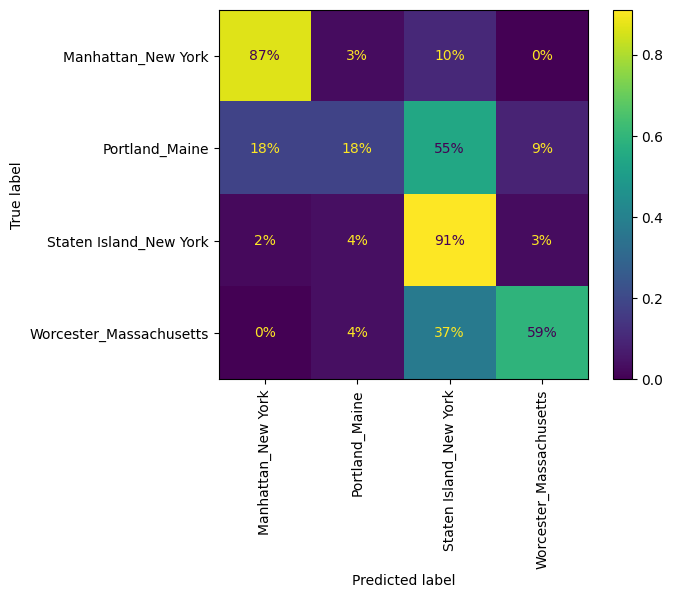

In [42]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test,
                                                y_pred,
                                                normalize='true',
                                                values_format=".0%",
                                                xticks_rotation='vertical')
plt.show()

42. Where does there seem to be the most confusion (i.e. which classes seem to be confused for one another)?  Does this make sense given your scatter plots in questions 30-31?

In [43]:
print("""Predicted label 'Staten Island seem to be more confused on Portland_Maine and Worcester_massachusetts""")

Predicted label 'Staten Island seem to be more confused on Portland_Maine and Worcester_massachusetts


43. Use `metrics.classification_report` on the test data.  Print out the classification report.

In [44]:
print(metrics.classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

     Manhattan_New York       0.85      0.87      0.86        67
         Portland_Maine       0.24      0.18      0.21        22
 Staten Island_New York       0.89      0.91      0.90       268
Worcester_Massachusetts       0.62      0.59      0.60        27

               accuracy                           0.84       384
              macro avg       0.65      0.64      0.64       384
           weighted avg       0.83      0.84      0.83       384



44. What do your f1 scores tell you about which categories are easiest to classify and which are hardest?

In [45]:
print("""Manhattan_New York and Staten Island_New York are easier to classify whereas Portland_Maine and Worcester_Massachusetts are harder to classify.""")

Manhattan_New York and Staten Island_New York are easier to classify whereas Portland_Maine and Worcester_Massachusetts are harder to classify.


45. What recommendations would you give someone to improve their model

In [46]:
print("""I would recommend increasing the size of the datasets to get a bit more of a balance datasets to minimize confusion and get more accuracy.""")

I would recommend increasing the size of the datasets to get a bit more of a balance datasets to minimize confusion and get more accuracy.


# Bonus (10 Points)

46. Use a label encoder on the y variable train data to encode as numbers instead of strings.  Use the same label encoder on the test data to transform that data as well.


In [47]:
label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)

47. Fit a model on only price and house_size.  Use the scaled data and the parameters from your best model above (use an SVC, not Logistic Regression) and the newly encoded y train as your y variable


In [48]:
svc = SVC(C=100, gamma=1)

svc.fit( X_train_scaled[['price', 'house_size']], y_train)

y_train_pred = svc.predict(X_train_scaled[['price', 'house_size']])
y_test_pred = svc.predict(X_test_scaled[['price', 'house_size']])

48. Print out the training and test accuracy and f1 scores (use macro average).  


In [49]:
print(metrics.accuracy_score(y_test, y_test_pred),
      metrics.f1_score(y_test, y_test_pred, average='macro'))

print(metrics.accuracy_score(y_train, y_train_pred),
      metrics.f1_score(y_train, y_train_pred, average='macro'))

0.8671875 0.6488478786615433
0.8840390879478828 0.6747298210064168


49. How does the test accuracy and f1_scores seem to compare to our model above that had bed and bath in them?


In [50]:
print("""There is no changes to the test or train accuraccy and f1-score""")

There is no changes to the test or train accuraccy and f1-score


50. Plot a confusion matrix with `normalize='true'` and `values_format=".0%"`.  Create a title indicating which labels from the label encoder correspond to which string


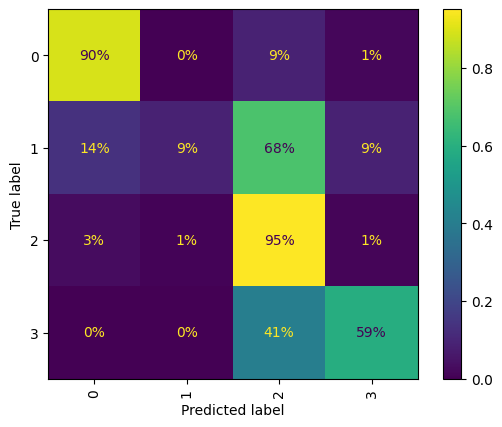

In [51]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test,
                                                y_test_pred,
                                                normalize='true',
                                                values_format=".0%",
                                                xticks_rotation='vertical')
plt.show()

51. Where does the confusion seem to be?


In [52]:
print("""Same areas as before just that model confusion increased.""")

Same areas as before just that model confusion increased.


52. Plot the decision boundary with only scatter plot for Manhattan and Worchester


53. Plot the decision boundary with scatter plot for all four categories

In [53]:
plt.show()

54. Do your decision boundaries make sense?

In [54]:
print("""Your answer here""")

Your answer here
